## Simulating the election model

To do this, 
we will assume that the outcome in each state is the result of an independent coin flip whose probability of coming up Obama is given by the Predictwise state-wise win probabilities. Lets write a function `simulate_election` that uses this **predictive model** to simulate the outcome of the election given a table of probabilities.

But first, what do we need to do to achieve this? We need to take the output of each simulation for a state and compare it to the predictiwise probability. Then we need to do this many times. Then we need to multiply in by the electoral votes in those states. And then sum over the states.

### Simulations on all states
Lets do it for all the states now. Now we make 1000 simulations for all the states. We'll create 51 rows of 1000 random numbers (1000 columns) between 0 and 1 & try and see in how many votes Obama is able to gather in each simulation

In [1]:
import numpy as np
import pandas as pd

In [2]:
predictwise = pd.read_csv('data/predictwise.csv').set_index('States')
predictwise.head()

,Obama,Romney,Votes
States,,,
Alabama,0.000,1.000,9
Alaska,0.000,1.000,3
Arizona,0.062,0.938,11
Arkansas,0.000,1.000,6
California,1.000,0.000,55


In [3]:
sims = np.random.uniform(size=(51, 1000))
print(sims.shape)
sims

(51, 1000)


array([[0.26768074, 0.551661  , 0.81778237, ..., 0.45266597, 0.17786018,
        0.80867117],
       [0.24960647, 0.03740239, 0.86650719, ..., 0.90074907, 0.16430389,
        0.92090899],
       [0.70286304, 0.39386331, 0.83166435, ..., 0.65157729, 0.85708897,
        0.35358506],
       ...,
       [0.75230804, 0.46078325, 0.26914989, ..., 0.64631506, 0.97192791,
        0.44420078],
       [0.17988242, 0.66285787, 0.08780251, ..., 0.87787318, 0.12749814,
        0.95116022],
       [0.43344962, 0.91718346, 0.27636479, ..., 0.71190797, 0.13381003,
        0.31014514]])

Now we just need to compare each row of 1000 random numbers with the probability for that state to find how many of the simulations Obama wins:

In [4]:
sims < predictwise.Obama.values

ValueError: operands could not be broadcast together with shapes (51,1000) (51,) 

Doing this creates an error as the shape of **sims** and **predictwise.Obama.values** is not the same. We can use numpy.reshape to change the shape of our array

## Comparing simulations and numpy.reshape

Reshape gives a new shape to the array without changing the data.  Detailed documentation about reshape [here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html). Let us take an example to show how reshape works

In [5]:
a= np.arange(6)
print(a)
print(a.shape)

[0 1 2 3 4 5]
(6,)


In [6]:
a.reshape(2,3)

array([[0, 1, 2],
       [3, 4, 5]])

In [7]:
a.reshape(6,1)

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5]])

In [8]:
a.reshape(1,6)

array([[0, 1, 2, 3, 4, 5]])

In [9]:
print(a.reshape(-1,1))   # -1 as a parameter simply means that it is an unknown dimension and we want numpy to figure it out.
print('New shape is: ', a.reshape(-1,1).shape)

[[0]
 [1]
 [2]
 [3]
 [4]
 [5]]
New shape is:  (6, 1)


If we use `reshape` now to our predictwise Obama proababilities, we get 51 rows of 100 Trues and Falses

In [10]:
how_many_won = sims < predictwise.Obama.values.reshape(-1,1) # reshape for broadcasting
how_many_won

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True, False],
       [False, False, False, ..., False, False, False]])

In [11]:
how_many_won.shape

(51, 1000)

In [14]:
np.sum(how_many_won.sum(axis=1) > 500)

27

Multiply by the number of electoral Votes in each state

In [15]:
predictwise.Votes

States
Alabama                  9
Alaska                   3
Arizona                 11
Arkansas                 6
California              55
Colorado                 9
Connecticut              7
Delaware                 3
District of Columbia     3
Florida                 29
Georgia                 16
Hawaii                   4
Idaho                    4
Illinois                20
Indiana                 11
Iowa                     6
Kansas                   6
Kentucky                 8
Louisiana                8
Maine                    4
Maryland                10
Massachusetts           11
Michigan                16
Minnesota               10
Mississippi              6
Missouri                10
Montana                  3
Nebraska                 5
Nevada                   6
New Hampshire            4
New Jersey              14
New Mexico               5
New York                29
North Carolina          15
North Dakota             3
Ohio                    18
Oklahoma             

In [17]:
how_many_won.shape

(51, 1000)

In [18]:
how_many_electoral_votes = how_many_won*predictwise.Votes.values.reshape(-1,1)
how_many_electoral_votes

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [10, 10, 10, ..., 10, 10,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

If we sum the columns now (that is over the 50 states and DC), we get the total electoral votes in the country for Obama in each simulation

In [20]:
predictwise.Votes.sum()

538

In [21]:
total_electoral_votes_per_simulation = np.sum(how_many_electoral_votes, axis=0)
total_electoral_votes_per_simulation[:20]

array([313, 334, 338, 303, 317, 269, 341, 319, 270, 326, 303, 328, 314,
       309, 337, 294, 347, 304, 303, 328])

This is what Nate Silver and other prediction people will quote you. In How many simulations does Obama win? Well there are 538 electoral votes in the US. So you need 269 to break even. Lets compare:

In [22]:
np.sum(total_electoral_votes_per_simulation >= 269)

996

Thats 993 out of 1000 simulations or a 99.3% chance!

## Refactoring the simulation code

In the code below, each column simulates a single outcome from the 50 states + DC by choosing a random number between 0 and 1. Obama wins that simulation if the random number is $<$ the win probability. If he wins that simulation, we add in the electoral votes for that state, otherwise we dont. We do this `n_sim` times and return a list of total Obama electoral votes in each simulation.

We use our understanding of how simulation on the election model works to construct a function

In [24]:
def simulate_election(model, n_sim):
    # specifying size(x,y) creates uniform random numbers between 0 and 1 in a 2-d matrix with x rows and y columns
    simulations = np.random.uniform(size=(51, n_sim))
    obama_votes = (simulations < model.Obama.values.reshape(-1, 1)) * model.Votes.values.reshape(-1, 1)
    #summing over rows gives the total electoral votes for each simulation
    return obama_votes.sum(axis=0)

The following code takes the necessary probabilities for the Predictwise data, and runs 10000 simulations. If you think of this in terms of our coins, think of it as having 51 biased coins, one for each state, and tossing them 10,000 times each.

We use the results to compute the number of simulations, according to this predictive model, that Obama wins the election (i.e., the probability that he receives 269 or more electoral college votes)

In [25]:
result = simulate_election(predictwise, 10000)
print(type(result))
np.sum(result >= 269)

<class 'numpy.ndarray'>


9955

There are roughly only 50 simulations in which Romney wins the election!

### Displaying the prediction

Now, lets visualize the simulation. We will build a histogram from the result of `simulate_election`. We will **normalize** the histogram by dividing the frequency of a vote tally by the number of simulations. We'll overplot the "victory threshold" of 269 votes as a vertical black line and the result (Obama winning 332 votes) as a vertical red line.

We also compute the number of votes at the 5th and 95th quantiles, which we call the spread, and display it (this is an estimate of the outcome's uncertainty). By 5th quantile we mean that if we ordered the number of votes Obama gets in each simulation in increasing order, the 5th quantile is the number below which 5\% of the simulations lie. 

We also display the probability of an Obama victory, seeing a new feature in histograms, which is "density" plotting. Here we are normalizing the total frequency of the histogram to 1, to construct our notion of a probability from a large-number frquency.   

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt # imports the MATLAB compatible plotting API

In [29]:
def plot_simulation(simulation):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.hist(simulation, bins=np.arange(200, 538, 1), 
             label='simulations', align='left', density=True)
    ax.axvline(332, 0, .5, color='r', label='Actual Outcome')
    ax.axvline(269, 0, .5, color='k', label='Victory Threshold')
    p05 = np.percentile(simulation, 5.)
    p95 = np.percentile(simulation, 95.)
    iq = int(p95 - p05)
    pwin = ((simulation >= 269).mean() * 100)
    ax.set_title("Chance of Obama Victory: %0.2f%%, Spread: %d votes" % (pwin, iq))
    ax.legend(frameon=False, loc='upper left')
    ax.set_xlabel("Obama Electoral College Votes")
    ax.set_ylabel("Probability")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

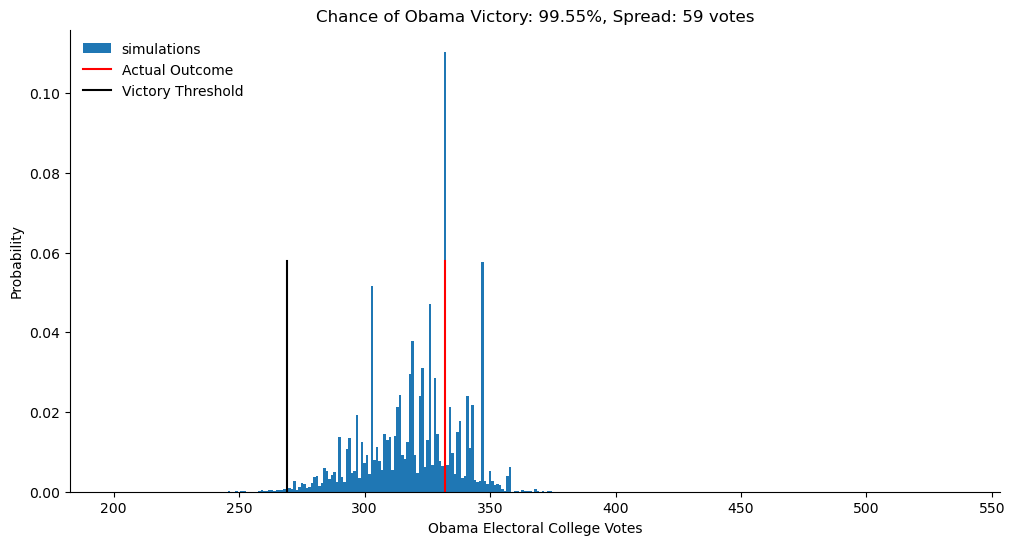

In [30]:
plot_simulation(result)

The model created by combining the probabilities we obtained from Predictwise with the simulation of a biased coin flip corresponding to the win probability in each states leads us to obtain a histogram of election outcomes. We are plotting the probabilities of a prediction, so we call this distribution over outcomes the **predictive distribution**. Simulating from our model and plotting a histogram allows us to visualize this predictive distribution. In general, such a set of probabilities is called a **probability distribution** or **probability mass function**. 

In [45]:
N=10000000
x = np.random.uniform(-1, 1, size=N)
y = np.random.uniform(-1, 1, size=N)

In [46]:
4*np.mean(x*x + y*y <= 1)

3.1421792

In [33]:
np.array([1,2,3])*np.array([1,2,3])

array([1, 4, 9])